<a href="https://colab.research.google.com/github/bzhang9683/ICML_CCAI_Workshop_2021/blob/main/Fine_Tuning_BERT_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch
import torch.nn as nn

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
!pip install transformers

     |████████████████████████████████| 2.3MB 4.3MB/s 
     |████████████████████████████████| 901kB 46.1MB/s 
     |████████████████████████████████| 3.3MB 50.6MB/s 


In [6]:
import pandas as pd

df_dir = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DIR_processed.csv")

title = df_dir.processed_title.values
labels = df_dir.iloc[:,-9:-2].values
categories = df_dir.columns.values[-9:-2]

In [7]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [8]:
# Print the original sentence.
print(' Original: ', title[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(title[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(title[0])))

 Original:  Maine Drought Task Force closed
Tokenized:  ['maine', 'drought', 'task', 'force', 'closed']
Token IDs:  [7081, 14734, 4708, 2486, 2701]


In [9]:
#maximum sentence length
max_len = 0

# For every sentence...
for sent in title:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  44


In [10]:
#tokenization
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in title:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', title[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Maine Drought Task Force closed
Token IDs: tensor([  101,  7081, 14734,  4708,  2486,  2701,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [10]:
input_ids.shape

torch.Size([14178, 64])

In [11]:
#training & validation split

from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
# 80% training set 10% validation 10% testing
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

11,342 training samples
1,417 validation samples
1,419 test samples


In [12]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
# For test the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [13]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 7

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H,D_out),
            nn.Sigmoid()
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 27.4 ms, sys: 3.16 ms, total: 30.6 ms
Wall time: 32.3 ms


In [14]:
from torchsummary import summary
bert_classifier = BertClassifier(freeze_bert=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [16]:
#muiltiple Metrics
from sklearn import metrics

def calculate_metrics(pred, target):
    #pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': metrics.precision_score(y_true=target, y_pred=pred, average='micro'),

            'micro/recall': metrics.recall_score(y_true=target, y_pred=pred, average='micro'),

            'micro/f1': metrics.f1_score(y_true=target, y_pred=pred, average='micro'),

            'macro/precision': metrics.precision_score(y_true=target, y_pred=pred, average='macro'),

            'macro/recall': metrics.recall_score(y_true=target, y_pred=pred, average='macro'),

            'macro/f1': metrics.f1_score(y_true=target, y_pred=pred, average='macro'),

            'samples/precision': metrics.precision_score(y_true=target, y_pred=pred, average='samples'),

            'samples/recall': metrics.recall_score(y_true=target, y_pred=pred, average='samples'),

            'samples/f1': metrics.f1_score(y_true=target, y_pred=pred, average='samples')
            }

In [17]:
import random
import time
import numpy as np
import os
# Specify loss function
loss_fn = nn.BCELoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Precision':^9} | {'Val Recall':^9} | {'Val F1':^9} | {'Elapsed':^9}")
        print("-"*100)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels.type(torch.float))
            batch_loss += loss.item()
            total_loss += loss.item()
            #print(loss,logits.shape)
            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12f} | {'-':^10} | {'-':^13} | {'-':^10} | {'-':^9} | {time_elapsed:^9f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
                

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*100)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_precision, val_recall, val_f1 = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            # Print the header of the result table
            
            print("-"*100)
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_precision:^13f} | {val_recall:^10.2f} | {val_f1:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*100)
        print("\n")
    
    print("Training complete!")

    #saving the model
    '''
    # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
    output_dir = './model_save/'

    # Create output directory if needed
    if not os.path.exists(output_dir):
      os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)

    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    '''

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_precision = []
    val_recall = []
    val_f1 = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels.type(torch.float))
        val_loss.append(loss.item())

        # Get the predictions
        logits_arr = logits.cpu().numpy()
        logits_arr[logits_arr>=0.5] = 1
        logits_arr[logits_arr<0.5] = 0

        b_labels_arr = b_labels.cpu().numpy()
        # Calculate the accuracy rate
        precision_micro = metrics.precision_score(y_true=b_labels_arr, y_pred=logits_arr, average='micro')
        val_precision.append(precision_micro)
        recall_micro = metrics.recall_score(y_true=b_labels_arr, y_pred=logits_arr, average='micro')
        val_recall.append(recall_micro)
        f1_micro = metrics.f1_score(y_true=b_labels_arr, y_pred=logits_arr, average='micro')
        val_f1.append(f1_micro)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_precision = np.mean(precision_micro)
    val_recall = np.mean(recall_micro)
    val_f1 = np.mean(f1_micro)

    return val_loss, val_precision, val_recall, val_f1

In [19]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, validation_dataloader, epochs=4, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  | Val Precision | Val Recall |  Val F1   |  Elapsed 
----------------------------------------------------------------------------------------------------
   1    |   20    |   0.559518   |     -      |       -       |     -      |     -     | 4.499779 
   1    |   40    |   0.454259   |     -      |       -       |     -      |     -     | 4.104342 
   1    |   60    |   0.381290   |     -      |       -       |     -      |     -     | 4.097119 
   1    |   80    |   0.351349   |     -      |       -       |     -      |     -     | 4.100087 
   1    |   100   |   0.326943   |     -      |       -       |     -      |     -     | 4.103514 
   1    |   120   |   0.315613   |     -      |       -       |     -      |     -     | 4.106225 
   1    |   140   |   0.304366   |     -      |       -       |     -      |     -     | 4.089532 
   1    |   160   |   0.289780   |     -      |       -       |     -      |     -     |

In [20]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits.type(torch.float))
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = all_logits.cpu().numpy()

    return probs

In [21]:
test_labels = np.array([])
for i, data in enumerate(test_dataloader):
    test_labels = np.append(test_labels, data[2].numpy())
test_labels = test_labels.reshape(1419,7)
test_labels.shape

(1419, 7)

In [22]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs > threshold, 1, 0)

# Number of tweets predicted non-negative
#print("Labels of tweets predicted: ", preds)

results = calculate_metrics(pred = preds,target = test_labels.astype("int"))
print(f'Micro Precision: {results["micro/precision"]:.4f}')
print(f'Micro Recall: {results["micro/recall"]:.4f}')
print(f'Mirco F1: {results["micro/f1"]:.4f}')
print(f'Macro Precision: {results["macro/precision"]:.4f}')
print(f'Macro Recall: {results["macro/recall"]:.4f}')
print(f'Macro F1: {results["macro/f1"]:.4f}')

Micro Precision: 0.8856
Micro Recall: 0.7906
Mirco F1: 0.8354
Macro Precision: 0.8647
Macro Recall: 0.7428
Macro F1: 0.7953


In [23]:
np.unique(test_labels)

array([0., 1.])

In [24]:
import matplotlib.pyplot as plt
def evaluate_roc(probs, y_true, title_category):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs
    fpr, tpr, threshold = metrics.roc_curve(y_true, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic for '+title_category)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9806
Accuracy: 94.71%


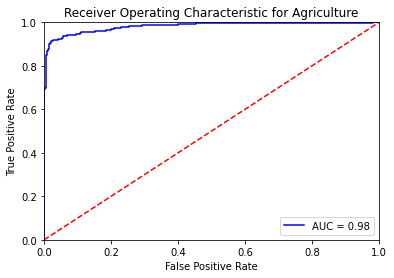

Precision: 0.9199
Recall: 0.9479
F1: 0.9337


In [25]:
# Evaluate the Bert classifier
evaluate_roc(probs[:,0], test_labels[:,0],categories[0])

#Generate various metrics
print(f'Precision: {metrics.precision_score(preds[:,0], test_labels[:,0]):.4f}')
print(f'Recall: {metrics.recall_score(preds[:,0], test_labels[:,0]):.4f}')
print(f'F1: {metrics.f1_score(preds[:,0], test_labels[:,0]):.4f}')

Precision: 0.5714
Recall: 0.8595
F1: 0.6865
AUC: 0.9098
Accuracy: 93.31%


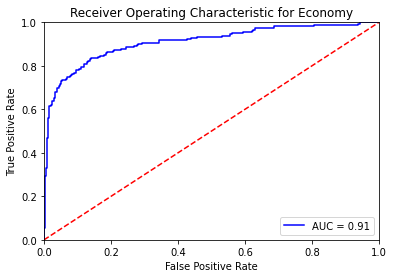

In [26]:
#Generate various metrics
print(f'Precision: {metrics.precision_score(preds[:,1], test_labels[:,1]):.4f}')
print(f'Recall: {metrics.recall_score(preds[:,1], test_labels[:,1]):.4f}')
print(f'F1: {metrics.f1_score(preds[:,1], test_labels[:,1]):.4f}')

evaluate_roc(probs[:,1], test_labels[:,1],categories[1])

Precision: 0.8517
Recall: 0.9537
F1: 0.8998
AUC: 0.9518
Accuracy: 96.12%


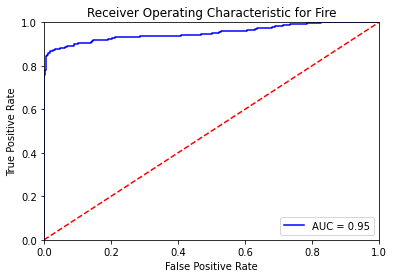

In [27]:
#Generate various metrics
print(f'Precision: {metrics.precision_score(preds[:,2], test_labels[:,2]):.4f}')
print(f'Recall: {metrics.recall_score(preds[:,2], test_labels[:,2]):.4f}')
print(f'F1: {metrics.f1_score(preds[:,2], test_labels[:,2]):.4f}')

evaluate_roc(probs[:,2], test_labels[:,2],categories[2])

Precision: 0.7060
Recall: 0.8046
F1: 0.7521
AUC: 0.9095
Accuracy: 85.27%


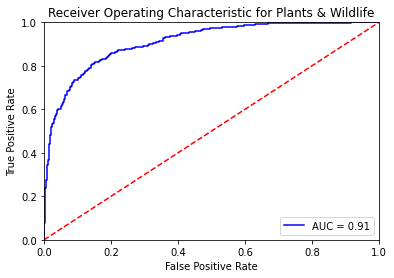

In [28]:
#Generate various metrics
print(f'Precision: {metrics.precision_score(preds[:,3], test_labels[:,3]):.4f}')
print(f'Recall: {metrics.recall_score(preds[:,3], test_labels[:,3]):.4f}')
print(f'F1: {metrics.f1_score(preds[:,3], test_labels[:,3]):.4f}')

evaluate_roc(probs[:,3], test_labels[:,3],categories[3])

Precision: 0.8655
Recall: 0.9055
F1: 0.8851
AUC: 0.9599
Accuracy: 92.46%


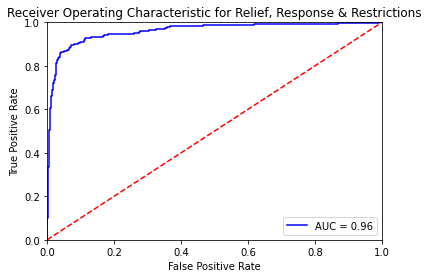

In [29]:
#Generate various metrics
print(f'Precision: {metrics.precision_score(preds[:,4], test_labels[:,4]):.4f}')
print(f'Recall: {metrics.recall_score(preds[:,4], test_labels[:,4]):.4f}')
print(f'F1: {metrics.f1_score(preds[:,4], test_labels[:,4]):.4f}')

evaluate_roc(probs[:,4], test_labels[:,4],categories[4])

Precision: 0.4740
Recall: 0.7000
F1: 0.5652
AUC: 0.8888
Accuracy: 90.13%


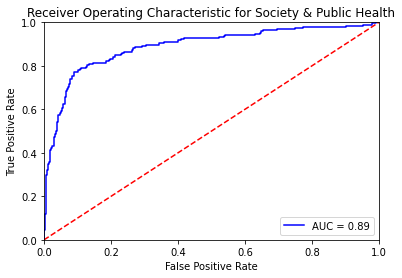

In [30]:
#Generate various metrics
print(f'Precision: {metrics.precision_score(preds[:,5], test_labels[:,5]):.4f}')
print(f'Recall: {metrics.recall_score(preds[:,5], test_labels[:,5]):.4f}')
print(f'F1: {metrics.f1_score(preds[:,5], test_labels[:,5]):.4f}')

evaluate_roc(probs[:,5], test_labels[:,5],categories[5])

Precision: 0.8109
Recall: 0.8814
F1: 0.8447
AUC: 0.9363
Accuracy: 88.44%


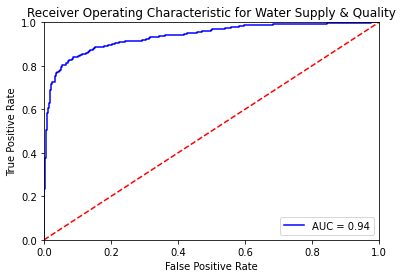

In [31]:
#Generate various metrics
print(f'Precision: {metrics.precision_score(preds[:,6], test_labels[:,6]):.4f}')
print(f'Recall: {metrics.recall_score(preds[:,6], test_labels[:,6]):.4f}')
print(f'F1: {metrics.f1_score(preds[:,6], test_labels[:,6]):.4f}')

evaluate_roc(probs[:,6], test_labels[:,6],categories[6])

In [33]:
bert_classifier

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru